In [1]:
from __future__ import division
import timeit
import scipy
import operator
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [67]:
data = pd.read_csv("../Data/prosper_final.csv")
data.head()

,ListingKey,FirstBidCreationDate,LastBidCreationDate,NoBids,AmountRequested,AvgInterBidTime,Gini,DebtToIncomeRatio,DescriptionLength,RepaidOrNot,...,Role_Count,Group_Count,Watching,MemberCreationDate,BorrowerTotalListings,BorrowerSuccessfulListings,BorrowerListingSuccessRate,TimeToFirstBid,TimeBetweenFirstLastBid,BorrowerAge
0,00033425227988088FA6752,2008-06-21 22:38:29,2008-06-23 06:08:09,15,1000.000,3101.733,0.167,0.190,190,1,...,3,3,3,2008-06-12 16:44:38,3,2,0.667,188.717,449.667,9
1,7B343428727859426204CF7,2008-08-05 19:49:08,2008-08-09 13:22:12,14,2200.000,22880.643,0.539,0.190,383,1,...,3,3,3,2008-06-12 16:44:38,3,2,0.667,75.767,1053.067,54
2,000433785890431972B4743,2007-01-03 09:11:14,2007-01-05 14:05:06,30,2550.000,8520.767,0.298,0.100,577,0,...,1,3,3,2006-05-10 16:13:00,2,1,0.500,1180.600,293.867,236
3,00083422661625108817246,2008-06-05 22:22:35,2008-06-12 22:03:28,141,3500.000,10633.589,0.198,0.350,210,1,...,1,3,3,2008-05-26 10:52:14,1,1,1.000,636.233,1420.883,0
4,000A34209897973969CFA81,2008-05-09 17:31:57,2008-05-15 15:17:26,2,1500.000,47348.000,0.468,0.040,134,1,...,2,3,3,2008-05-07 11:04:48,2,2,1.000,138.267,1305.483,1


## Credit Grade

In [77]:
# credit_grade = Counter(data[["MemberKey", "CreditGrade"]].groupby("MemberKey").agg(max).reset_index()["CreditGrade"])
credit_grade = Counter(data.CreditGrade)

Counter({5L: 5643, 4L: 5151, 9L: 5034, 6L: 4386, 8L: 3510, 2L: 3504, 7L: 3312, 3L: 3288, 1L: 140})


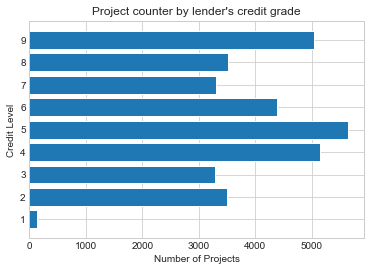

In [82]:
credit_grade_labels  = []
credit_grade_values = []
print credit_grade
for key, value in credit_grade.items():
    credit_grade_labels.append(key)
    credit_grade_values.append(value)

ind = np.arange(len(credit_grade_values)) 

fig, ax = plt.subplots()
y_pos = list(reversed(np.arange(len(credit_grade_labels))))
performance = credit_grade_values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(credit_grade_labels)
ax.invert_yaxis()
ax.set_ylabel("Credit Level")
ax.set_xlabel('Number of Projects')
ax.set_title('Project counter by lender\'s credit grade')

plt.show()

In [107]:
listings_by_credit_grade = data[["CreditGrade", "RepaidOrNot"]].groupby(["CreditGrade", "RepaidOrNot"]).size().reset_index()
# listings_by_credit_grade

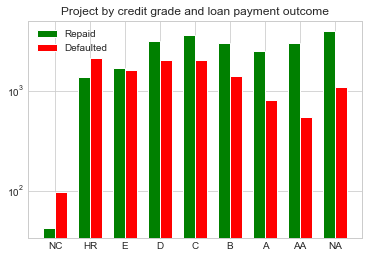

In [76]:
N = listings_by_credit_grade.CreditGrade.nunique()

repaid = list(listings_by_credit_grade.loc[listings_by_credit_grade.RepaidOrNot==1][0])

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, repaid, width, color='g', bottom=0, )

default = list(listings_by_credit_grade.loc[listings_by_credit_grade.RepaidOrNot==0][0])
p2 = ax.bar(ind + width, default, width, color='r', bottom=0, )

ax.set_title('Project by credit grade and loan payment outcome')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA', 'NA'))

ax.legend((p1[0], p2[0]), ('Repaid', 'Defaulted'))
ax.set_yscale("log")
ax.autoscale_view()

plt.show()

## Home Ownership

In [100]:
listing_data = pd.read_csv('../Data/listing.txt', sep="|")
listing_data = listing_data[["Lst_Key", "IsBorrowerHomeowner"]]
project_data = pd.read_csv('../Data/ProjectLevelData.txt', sep="|")
project_data = project_data[["ListingKey", "FundedOrNot", "RepaidOrNot"]]
listing_data = listing_data.rename(index=str, columns={"Lst_Key": "ListingKey"})
listing_data = listing_data.merge(project_data, on="ListingKey")
listing_data["IsBorrowerHomeowner"] = listing_data.IsBorrowerHomeowner.fillna("Unknown")
listing_data.head()

,ListingKey,IsBorrowerHomeowner,FundedOrNot,RepaidOrNot
0,3DC53364505797332A768BE,Unknown,False,NaN
1,6B163364972327951803D98,Unknown,False,NaN
2,51593365733195992745BA9,Unknown,False,NaN
3,81BA336634592783114E9EB,Unknown,False,NaN
4,F7C433651616107108B5E83,Unknown,False,NaN


In [108]:
homeowner_data = listing_data[["IsBorrowerHomeowner", "RepaidOrNot"]].groupby(["IsBorrowerHomeowner", "RepaidOrNot"]).size().reset_index()
# homeowner_data

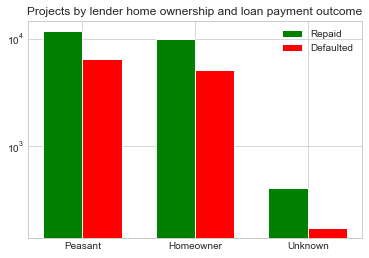

In [105]:
N = 3

repaid = list(homeowner_data.loc[homeowner_data.RepaidOrNot==1][0])

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, repaid, width, color='g', bottom=0, )

default = list(homeowner_data.loc[homeowner_data.RepaidOrNot==0][0])
p2 = ax.bar(ind + width, default, width, color='r', bottom=0, )

ax.set_title('Projects by lender home ownership and loan payment outcome')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Peasant', 'Homeowner', 'Unknown'))

ax.legend((p1[0], p2[0]), ('Repaid', 'Defaulted'))
ax.set_yscale("log")
ax.autoscale_view()

plt.show()

## Feature Permutation